## Importing Packages

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import textblob

from textblob import TextBlob
from textblob import Word
#from spellchecker import SpellChecker
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [201]:
# Load the Excel file into a DataFrame
df_SA = pd.read_excel('amazon_review_processed_full.xlsx')

df_SA['ID'] = range(0, len(df_SA))

# Display the DataFrame
df_SA.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,title_word_count,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,ID
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,works great,easy install works great,True,0.0,False,...,2,38,11,3.875000,5.000000,3,0,Canon,works great easy install works great,0
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,slower speed im used old model 8600 new 9015e ...,True,0.0,False,...,4,460,23,4.835443,5.000000,19,0,HP,spunky mid size slower speed im used old model...,1
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0.0,False,...,2,7,12,3.000000,5.500000,0,0,Canon,i,2
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag knows hes talking,yup slam upgrade paid little front equivalent ...,True,12.0,False,...,6,469,34,4.595238,4.833333,31,2,Epson,shag knows hes talking yup slam upgrade paid l...,3
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,would think something simple reconnecting wifi...,True,0.0,False,...,3,861,17,4.387500,5.000000,71,0,HP,user friendly would think something simple rec...,4


## Vader Sentiment Scoring on Original Review Content

In [202]:
sia = SentimentIntensityAnalyzer()

In [203]:
#Converting Review Content to string type in order to run Vader Sentiment Analysis
df_SA['Review Content'] = df_SA['Review Content'].astype(str)

### Running the Vader Sentiment Analysis

In [204]:
# Running the polarity score on the entire dataset
res = {}
for i, row in tqdm(df_SA.iterrows(), total=len(df_SA)):
    text = row['Review Content']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10209 [00:00<?, ?it/s]

In [205]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'ID'})
vaders = vaders.merge(df_SA, how='left')

In [206]:
vaders[['Review rating','compound']]

,Review rating,compound
0,5,0.7906
1,3,0.9557
2,4,0.0000
3,5,0.7773
4,3,-0.5574
...,...,...
10204,5,0.0000
10205,5,0.0000
10206,1,0.0000
10207,1,0.0000


## Plotting VADER results on Original Review Content

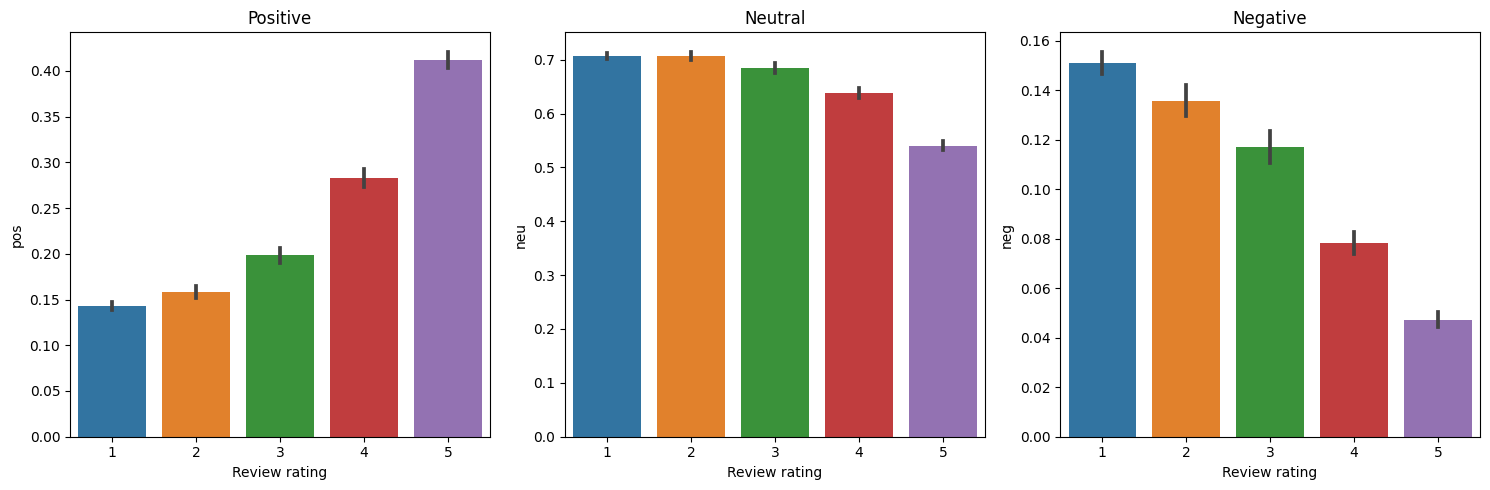

In [27]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data=vaders, x='Review rating', y = 'pos', ax=axs[0])
sns.barplot(data=vaders, x='Review rating', y = 'neu', ax=axs[1])
sns.barplot(data=vaders, x='Review rating', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Remarks: As expected, for ratings that are higher, they are more likely to get a higher positive score, while ratings that are lower got a higher negative score.

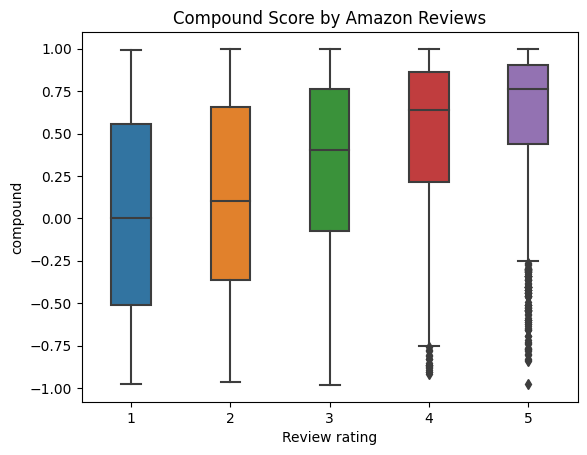

In [210]:
ax = sns.boxplot(x="Review rating", y="compound", data=vaders, width=0.4)
ax.set_title('Compound Score by Amazon Reviews')
plt.show()

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

positive sentiment : (compound score >= 0.05) 

neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 

negative sentiment : (compound score <= -0.05)

As we can see, lower ratings have more negative compound scores compared to higher ratings. For the higher ratings, there are a number of negative compound scores which may suggest wrong classification by the model which we will take a closer look in the next section

## Reviewing Examples

In [174]:
vaders = vaders.rename(columns={'Review rating': 'Review_rating'})

### Checking if the model works

In [178]:
# Positive sentiment with 5-star review
vaders.query('Review_rating == 5').sort_values('pos', ascending=False)['Review Content'].values[0:10]

array(['easy', 'great', 'nice', 'easy', 'good',
       'love easy nice clear great value', 'love', 'love', 'love easy',
       'love'], dtype=object)

In [179]:
# Negative sentiment with 1-star review
vaders.query('Review_rating == 1').sort_values('neg', ascending=False)['Review Content'].values[0:10]

array(['disgusting', 'bad', 'dislike', 'horrible', 'horrible', 'dislike',
       'terrible', 'mistake buying worst', 'worst ever',
       'absolutely hate'], dtype=object)

### Checking if the model produces inaccurate results

In [180]:
# Positive sentiment but with 1-star review
vaders.query('Review_rating == 1').sort_values('pos', ascending=False)['Review Content'].values[0:5]

array(['good', 'please careful product', 'good buy', 'please see',
       'save heartache dont buy awful'], dtype=object)

In [181]:
# Negative sentiment but with 5-star review
vaders.query('Review_rating == 5').sort_values('neg', ascending=False)['Review Content'].values[0:5]

array(['difficult', 'complaints', 'complaints buy',
       'difficult done works weird', 'fail de install'], dtype=object)

Some gave positive feedback but gave low ratings, while some gave negative feedback but high ratings. Might be inaccurate ratings on user's end or "troll" feedback

## Vader Sentiment Scoring on Review Content based on sentence split

#### Note: This is going to be used in conjuction with Topic Modelling, analysing the sentiments based on topics

In [124]:
# Load the Excel file into a DataFrame
df_SA_sent = pd.read_excel('amazon_review_processed_sents.xlsx')

# Creating a new Review ID column
df_SA_sent['Review ID'] = df_SA_sent['ID']
df_SA_sent['ID'] = range(0, len(df_SA_sent))

# Display the DataFrame
df_SA_sent.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,ID,Review ID
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,works great,['easy install works great'],True,0.0,False,...,38,11,3.875000,5.0,3,0,Canon,works great,0,1
1,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,works great,['easy install works great'],True,0.0,False,...,38,11,3.875000,5.0,3,0,Canon,easy install works great,1,1
2,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,spunky mid size,2,2
3,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,slower speed im used old model,3,2
4,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,8600 new 9015e sounds like breaking apart inside,4,2


#### Comparing the number of reviews for each rating after splitting into sentences

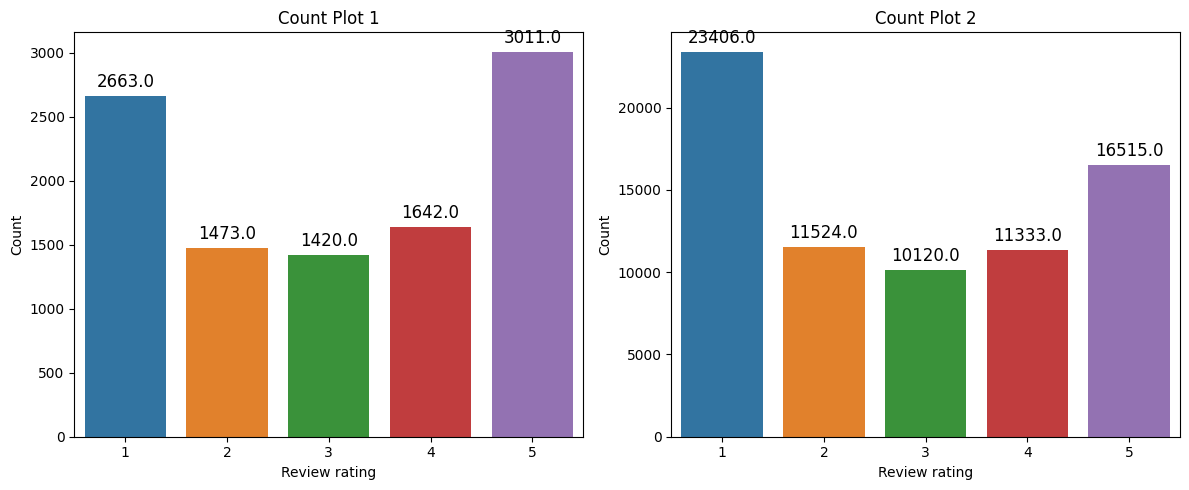

In [142]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first count plot
ax1 = sns.countplot(x="Review rating", data=df_SA, ax=axes[0])
axes[0].set_xlabel("Review rating")
axes[0].set_ylabel("Count")
axes[0].set_title("Count Plot 1")

# Add count labels on top of the bars for the first plot
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Plot the second count plot (can have different data or settings)
ax2 = sns.countplot(x="Review rating", data=df_SA_sent, ax=axes[1])
axes[1].set_xlabel("Review rating")
axes[1].set_ylabel("Count")
axes[1].set_title("Count Plot 2")

# Add count labels on top of the bars for the second plot
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Running the Vader Sentiment Analysis

In [149]:
# Running the polarity score on the entire dataset
res2 = {}
for i, row in tqdm(df_SA_sent.iterrows(), total=len(df_SA_sent)):
    text = row['Full review']
    myid = row['ID']
    res2[myid] = sia.polarity_scores(text)

  0%|          | 0/72898 [00:00<?, ?it/s]

In [154]:
vaders_sent = pd.DataFrame(res2).T
vaders_sent = vaders_sent.reset_index().rename(columns={'index':'ID'})
vaders_sent = vaders_sent.merge(df_SA_sent, how='left')

## Plotting VADER results on Review Content based on sentence split


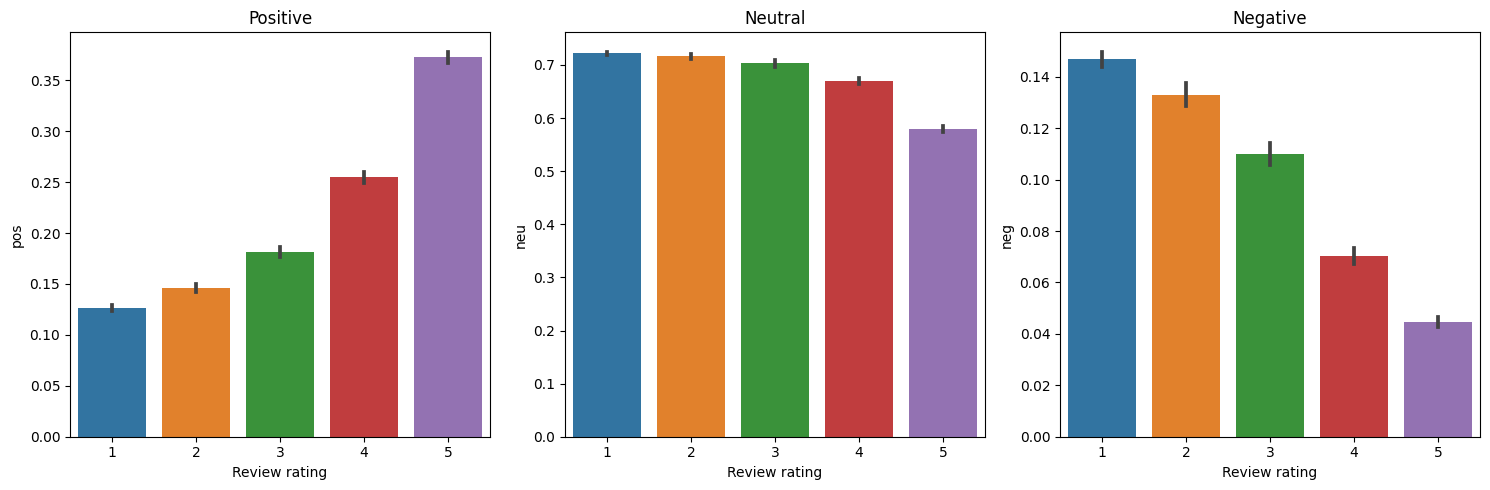

In [159]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data=vaders_sent, x='Review rating', y = 'pos', ax=axs[0])
sns.barplot(data=vaders_sent, x='Review rating', y = 'neu', ax=axs[1])
sns.barplot(data=vaders_sent, x='Review rating', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

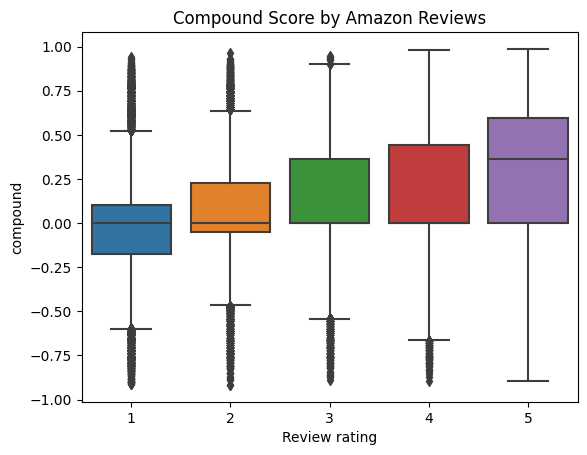

In [211]:
ax = sns.boxplot(data=vaders_sent, x='Review rating', y='compound')
ax.set_title('Compound Score by Amazon Reviews')
plt.show()

For the lower ratings, there seems to be quite a number of positive compound scores, which may suggest that certain sentences acknowledges that there are positive feedback but overall the negative outweighs the positives.

## Reviewing Examples

In [212]:
vaders_sent = vaders_sent.rename(columns={'Review rating': 'Review_rating'})

### Checking if the model works after splitting into sentence

In [217]:
# Positive sentiment with 5-star review
vaders_sent.query('Review_rating == 5').sort_values('pos', ascending=False)['Review Content'].values[0]

"['easy install', ' easy', ' works great']"

In [216]:
# Negative sentiment with 1-star review
vaders_sent.query('Review_rating == 1').sort_values('neg', ascending=False)['Review Content'].values[0]

"['convinced devices break couple months', ' luck common printers my buy locally always end buying', ' never', ' waste', ' favor buy absolutely anything else']"

### Checking if the model produces inaccurate results

In [218]:
# Positive sentiment but with 1-star review
vaders_sent.query('Review_rating == 1').sort_values('pos', ascending=False)['Review Content'].values[0]

"['loved first two canon pixma', ' canon model built much poorer parts flimsy like flip screen', ' spent hours although able unable scan totally imac old', ' every time tried support online via phone asked payment really purchased unit', ' helpful', ' sent back frustrating his', ' fortunately amazon honored free return']"

In [219]:
# Negative sentiment but with 5-star review
vaders_sent.query('Review_rating == 5').sort_values('neg', ascending=False)['Review Content'].values[0]

"['always love reason buy another upgrade windows 11 ugh', ' purchased two others epson brother', ' failures', ' maybe windows 11', ' made sure supported windows 11 os', ' weeks love far', ' ios app great well']"